In [114]:
# https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [115]:
from res.plot_lib import plot_data, plot_model, set_default

In [116]:
set_default()

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Geting Data

In [118]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

In [119]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)       

In [120]:
# a = next(iter(train_loader))
# plt.imshow(a[0][0][0])

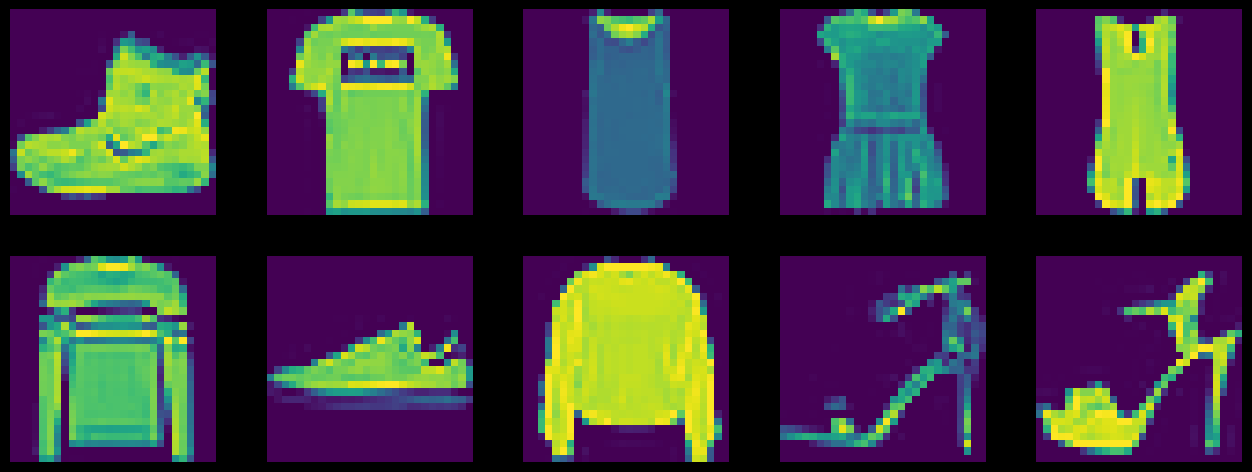

In [121]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [122]:
# Making a method that return the name of class for the label number. ex. if the label is 5, we return Sandal.
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### Buliding CNN

In [123]:
## Pre-prepared:

# class FashionCNN(nn.Module):
    
#     def __init__(self):
#         super(FashionCNN, self).__init__()
        
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=1)
#         )
        
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3)
#        )
        
        
#         self.fc1 = nn.Linear(in_features=100*6*6, out_features=800)
#         self.fc2 = nn.Linear(in_features=800, out_features=400)
#         self.fc3 = nn.Linear(in_features=400, out_features=120)
#         self.fc4 = nn.Linear(in_features= 120, out_features=10)
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = F.relu(out)
#         out = F.max_pool2d(out,kernel_size=2)
#         out = self.layer2(out)
#         out = F.relu(out)
#         out = F.max_pool2d(out,kernel_size=2)
#         out = out.view(out.size(0), -1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         out = self.fc2(out)
#         out = F.relu(out)
#         out = self.fc3(out)
#         out = F.relu(out)
#         out = self.fc4(out)
#         out = F.log_softmax(out,dim=1)
        
#         return out
    
#     def get_images1(self, x):
#         out = self.layer1(x)
#         out = F.relu(out)
#         out = F.max_pool2d(out,kernel_size=2)
        
#         return out
    
#     def get_images2(self,x):
#         out = self.layer1(x)
#         out = F.relu(out)
#         out = F.max_pool2d(out,kernel_size=2)
#         out = self.layer2(out)
#         out = F.relu(out)
#         out = F.max_pool2d(out,kernel_size=2)
        
#         return out



class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AvgPool2d(kernel_size=2)
       )
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm2d(100),
#             nn.MaxPool2d(kernel_size=2)
#        )
        
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=800)
        self.drop = nn.Dropout2d(0.40)
        self.fc2 = nn.Linear(in_features=800, out_features=120)
#         self.fc3 = nn.Linear(in_features=400, out_features=120)
        self.fc4 = nn.Linear(in_features = 120,out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
#         out = self.fc3(out)
#         out = F.relu(out)
        out = self.fc4(out)
        out = F.log_softmax(out,dim=1)
        
        return out
    
    def get_images1(self, x):
        return self.layer1(x)
    
    def get_images2(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [124]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=2304, out_features=800, bias=True)
  (drop): Dropout2d(p=0.4, inplace=False)
  (fc2): Linear(in_features=800, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=10, bias=True)
)


### Training and Testing

In [125]:
num_epochs = 8
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.3469407260417938, Accuracy: 89.56999969482422%
Iteration: 1000, Loss: 0.37950626015663147, Accuracy: 89.91999816894531%
Iteration: 1500, Loss: 0.16542518138885498, Accuracy: 91.31999969482422%
Iteration: 2000, Loss: 0.21793465316295624, Accuracy: 90.79999542236328%
Iteration: 2500, Loss: 0.1330883651971817, Accuracy: 90.94999694824219%
Iteration: 3000, Loss: 0.16042831540107727, Accuracy: 90.73999786376953%
Iteration: 3500, Loss: 0.14747372269630432, Accuracy: 91.18999481201172%
Iteration: 4000, Loss: 0.1742016077041626, Accuracy: 90.87999725341797%
Iteration: 4500, Loss: 0.04965467005968094, Accuracy: 91.44999694824219%


### Outputs of Layer1

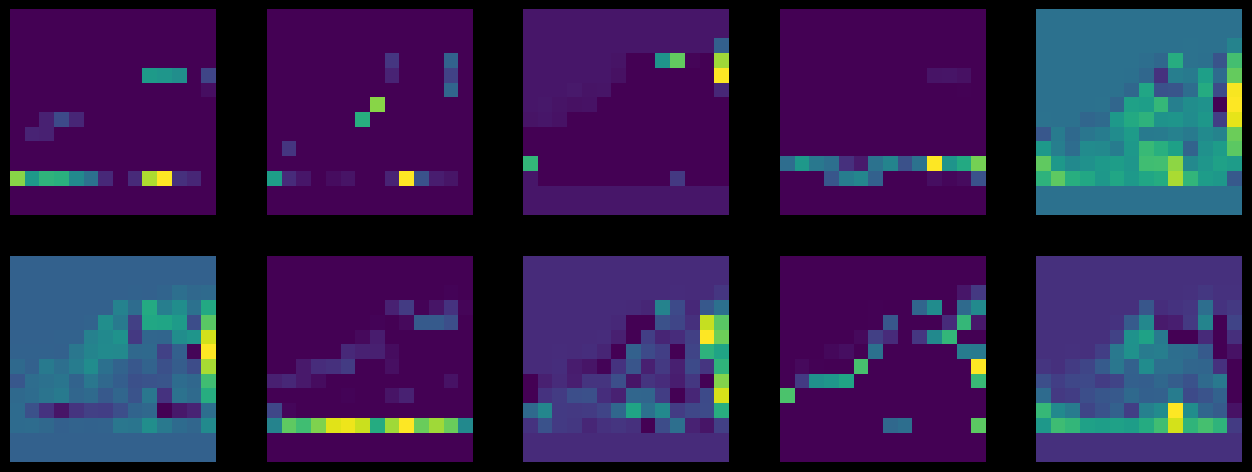

In [126]:
i = 0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    i += 1
    if i > 1:
        break
    outputs = model.get_images1(images)
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
#     image = outputs.__getitem__(i)
    plt.imshow(outputs[0].cpu().data.numpy()[i])
    plt.axis('off');

In [127]:
# outputs[0].cpu().data.numpy()

### Outputs of Layer2

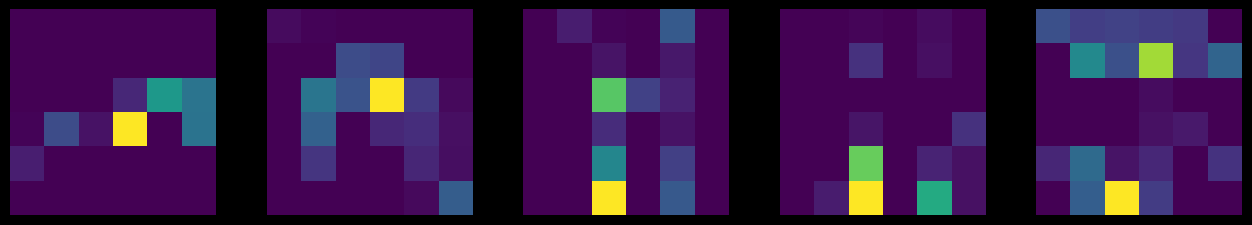

In [128]:
i = 0
for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    i += 1
    if i > 1:
        break
    outputs = model.get_images2(images)
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    image = outputs.__getitem__(i)
    plt.imshow(image[0].cpu().data.numpy())
    plt.axis('off');

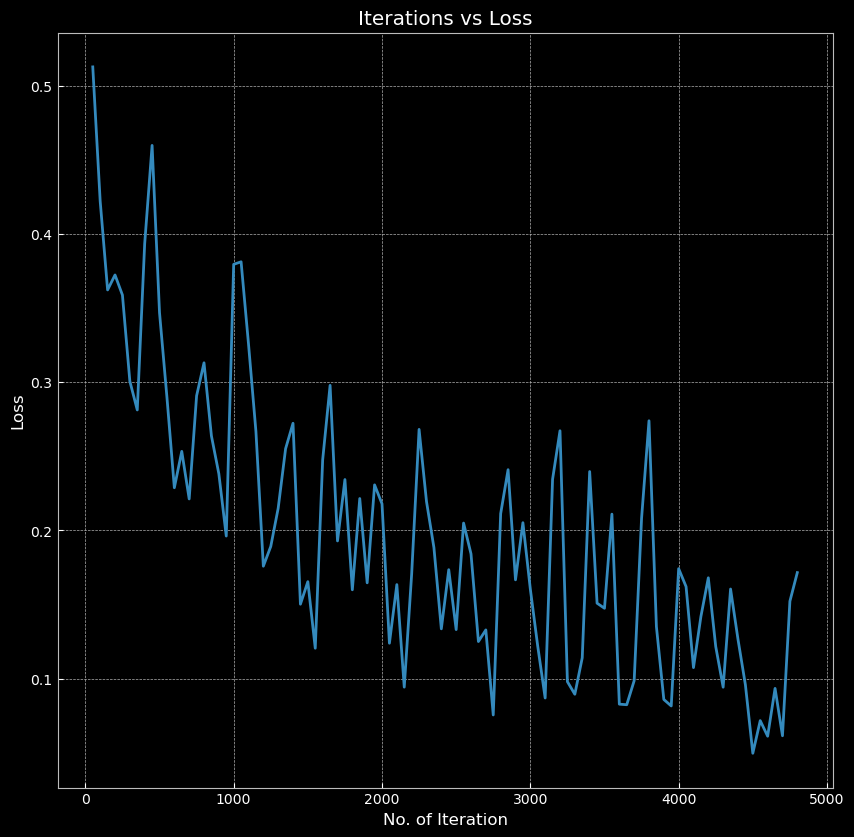

In [129]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

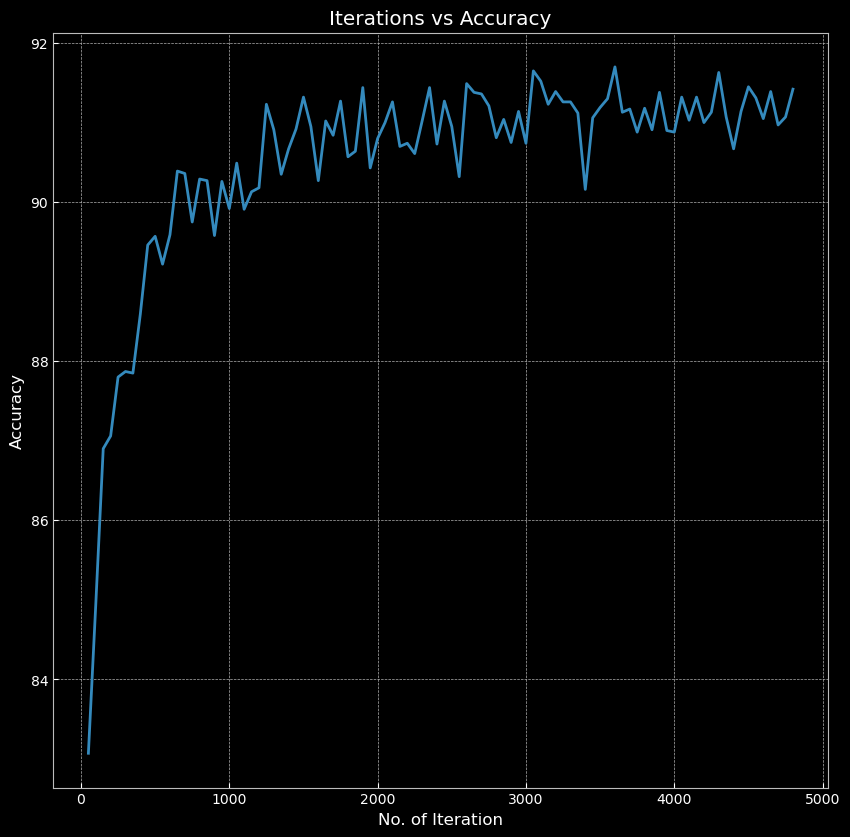

In [130]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()


In [131]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 89.00%
Accuracy of Trouser: 98.10%
Accuracy of Pullover: 89.00%
Accuracy of Dress: 94.80%
Accuracy of Coat: 83.00%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 71.40%
Accuracy of Sneaker: 96.00%
Accuracy of Bag: 97.80%
Accuracy of Ankle Boot: 97.70%


## Results

<h> Things to Check </h>
-  Average_Pooling vs Max_Pooling
-  Adjusting Convolution window size
-  Different Activation Functions
-  Number of Output Channels
-  Number of Convolution Layers
-  Number of Fully Connected Layers
-  Learning_Rates,Epochs,initilazation....

#### Average_pooling vs Max_pooling

<h> Average_Pooling Summary </h>
- Iteration: 500, Loss: 0.6217758655548096, Accuracy: 76.48999786376953%
- Iteration: 1000, Loss: 0.5764853954315186, Accuracy: 80.70999908447266%
- Iteration: 1500, Loss: 0.4094935655593872, Accuracy: 82.77999877929688%
- Iteration: 2000, Loss: 0.3952339291572571, Accuracy: 83.72999572753906%
- Iteration: 2500, Loss: 0.36742129921913147, Accuracy: 85.50999450683594%
- Iteration: 3000, Loss: 0.3093968629837036, Accuracy: 85.07999420166016%    
    
<h> Max_Pooling Summary</h>
- Iteration: 500, Loss: 0.6079098582267761, Accuracy: 77.5999984741211%
- Iteration: 1000, Loss: 0.5063292980194092, Accuracy: 83.45999908447266%
- Iteration: 1500, Loss: 0.45545709133148193, Accuracy: 83.07999420166016%
- Iteration: 2000, Loss: 0.35154134035110474, Accuracy: 86.19999694824219%
- Iteration: 2500, Loss: 0.26442116498947144, Accuracy: 87.2699966430664%
- Iteration: 3000, Loss: 0.2452133148908615, Accuracy: 87.91999816894531%
    
<h> Conclusion </h>

- As name suggests Average_pooling is Soft and max_pooling is sharp.
- I believe there is no much difference in performance and i think it is overfitting(??).
- Need to check for more modified Model

#### Adjusting Convolution window Size

<h> $ 3\times 3$ Summary</h>
- Iteration: 500, Loss: 0.5865272879600525, Accuracy: 80.5199966430664%
- Iteration: 1000, Loss: 0.44755619764328003, Accuracy: 84.18000030517578%
- Iteration: 1500, Loss: 0.39746540784835815, Accuracy: 83.08999633789062%
- Iteration: 2000, Loss: 0.33785074949264526, Accuracy: 86.2699966430664%
- Iteration: 2500, Loss: 0.29281023144721985, Accuracy: 87.6199951171875%
- Iteration: 3000, Loss: 0.23836253583431244, Accuracy: 87.58999633789062%

<h> $ 5\times 5$ Summary</h>
- Iteration: 500, Loss: 0.5387158393859863, Accuracy: 81.3699951171875%
- Iteration: 1000, Loss: 0.5224775075912476, Accuracy: 85.11000061035156%
- Iteration: 1500, Loss: 0.37437084317207336, Accuracy: 85.31999969482422%
- Iteration: 2000, Loss: 0.3225984573364258, Accuracy: 87.02999877929688%
- Iteration: 2500, Loss: 0.2803797423839569, Accuracy: 87.3699951171875%
- Iteration: 3000, Loss: 0.23874984681606293, Accuracy: 87.61000061035156%

<h> Conclusion: </h>
- It seems not much difference in results but the outputs of layer1 are good/ok/understandable for $5 \times 5$ kernel where as 
  for $3 \times 3$ it is not fine.
  
<h> More:: </h>
- Anything is perferable,no rules
- With averge_pooling:($ 5 \times 5$ kernel)
    - Iteration: 500, Loss: 0.6225598454475403, Accuracy: 74.94999694824219%
    - Iteration: 1000, Loss: 0.5429695248603821, Accuracy: 81.18999481201172%
    - Iteration: 1500, Loss: 0.4180496633052826, Accuracy: 82.43000030517578%
    - Iteration: 2000, Loss: 0.400076687335968, Accuracy: 84.00999450683594%
    - Iteration: 2500, Loss: 0.34212633967399597, Accuracy: 85.55999755859375%
    - Iteration: 3000, Loss: 0.320212185382843, Accuracy: 85.6199951171875%
- With average_pooling($ 3 \times 3 $ kernel)
    - Iteration: 500, Loss: 0.6084163784980774, Accuracy: 79.08999633789062%
    - Iteration: 1000, Loss: 0.5069544911384583, Accuracy: 83.19999694824219%
    - Iteration: 1500, Loss: 0.38887909054756165, Accuracy: 83.47000122070312%
    - Iteration: 2000, Loss: 0.3616446554660797, Accuracy: 85.45999908447266%
    - Iteration: 2500, Loss: 0.318341463804245, Accuracy: 86.44999694824219%
    - Iteration: 3000, Loss: 0.29311689734458923, Accuracy: 86.58999633789062%
    
- So finally first doing $3 \times 3$ and average_pooling and the $5 \times 5$ and then max_pooling.I feel like $3 \times 3 $ followed by averge pooling is good then $3 \times 3$ followed by by max_pooling similarly $5 \times 5$ followed by max_pooling(only from my intution after seeing layer1 images)
- Result with $3 \times 3$ and average_pooling followed by $5 \times 5$ and max_pooling.
    - Iteration: 500, Loss: 0.5736953020095825, Accuracy: 78.4000015258789%
    - Iteration: 1000, Loss: 0.46818745136260986, Accuracy: 84.63999938964844%
    - Iteration: 1500, Loss: 0.35661470890045166, Accuracy: 84.37999725341797%
    - Iteration: 2000, Loss: 0.26089784502983093, Accuracy: 86.77999877929688%
    - Iteration: 2500, Loss: 0.2193337082862854, Accuracy: 87.93999481201172%
    - Iteration: 3000, Loss: 0.21424227952957153, Accuracy: 87.70999908447266%
- Reverse of above configuration
    - Iteration: 500, Loss: 0.5781247615814209, Accuracy: 80.3699951171875%
    - Iteration: 1000, Loss: 0.4492659866809845, Accuracy: 84.19999694824219%
    - Iteration: 1500, Loss: 0.39429306983947754, Accuracy: 84.79000091552734%
    - Iteration: 2000, Loss: 0.3357504904270172, Accuracy: 86.72000122070312%
    - Iteration: 2500, Loss: 0.24308648705482483, Accuracy: 87.8499984741211%
    - Iteration: 3000, Loss: 0.27105867862701416, Accuracy: 87.97000122070312%


## Different Activation Functions:
- Not satisfied with tanh,sigmoid activation relu seems better

## Number of output Channels:

- Need to keep in increasing pattern.
- First level1 has 16 ouput channels and level2 has 32 channels
    - Iteration: 500, Loss: 0.5527979135513306, Accuracy: 82.81999969482422%
    - Iteration: 1000, Loss: 0.4356045424938202, Accuracy: 85.36000061035156%
    - Iteration: 1500, Loss: 0.37093690037727356, Accuracy: 85.33999633789062%
    - Iteration: 2000, Loss: 0.27641183137893677, Accuracy: 87.6199951171875%
    - Iteration: 2500, Loss: 0.22711440920829773, Accuracy: 88.54999542236328%
    - Iteration: 3000, Loss: 0.23455120623111725, Accuracy: 88.68000030517578%
    
- Even more???
 - First level1 has 25 ouput channels and level2 has 50 channels
    - Iteration: 500, Loss: 0.5520749092102051, Accuracy: 82.79000091552734%
    - Iteration: 1000, Loss: 0.4224318265914917, Accuracy: 86.13999938964844%
    - Iteration: 1500, Loss: 0.3514845669269562, Accuracy: 85.81999969482422%
    - Iteration: 2000, Loss: 0.286495566368103, Accuracy: 88.23999786376953%
    - Iteration: 2500, Loss: 0.21493516862392426, Accuracy: 89.22000122070312%
    - Iteration: 3000, Loss: 0.23402702808380127, Accuracy: 88.88999938964844%
 - First level1 has 32 ouput channels and level2 has 64 channels
    - Iteration: 500, Loss: 0.5288337469100952, Accuracy: 83.61000061035156%
    - Iteration: 1000, Loss: 0.38062533736228943, Accuracy: 86.57999420166016%
    - Iteration: 1500, Loss: 0.3205176591873169, Accuracy: 86.1199951171875%
    - Iteration: 2000, Loss: 0.23642241954803467, Accuracy: 88.82999420166016%
    - Iteration: 2500, Loss: 0.20027194917201996, Accuracy: 89.18000030517578%
    - Iteration: 3000, Loss: 0.23303134739398956, Accuracy: 88.70999908447266%
- I feel like it is overfitting so there is not net increase in accuracy

## Number of convolution layers

- in previous it is 2
- Now we check for 3
    - Iteration: 500, Loss: 0.5749520063400269, Accuracy: 80.72999572753906%
    - Iteration: 1000, Loss: 0.4845883548259735, Accuracy: 84.48999786376953%
    - Iteration: 1500, Loss: 0.4419015944004059, Accuracy: 83.63999938964844%
    - Iteration: 2000, Loss: 0.2819763720035553, Accuracy: 87.58999633789062%
    - Iteration: 2500, Loss: 0.24613671004772186, Accuracy: 88.43999481201172%
    - Iteration: 3000, Loss: 0.23191343247890472, Accuracy: 88.68000030517578%
    
- OK! Good lets see!!

## Number of Fully connected Layers

- previous we have 2 now lets try 3:(number of parameters increases heavely 😥
    - Iteration: 500, Loss: 0.597537100315094, Accuracy: 78.47999572753906%
    - Iteration: 1000, Loss: 0.4173266589641571, Accuracy: 82.93000030517578%
    - Iteration: 1500, Loss: 0.498958945274353, Accuracy: 83.5199966430664%
    - Iteration: 2000, Loss: 0.3039470613002777, Accuracy: 86.75999450683594%
    - Iteration: 2500, Loss: 0.2372046858072281, Accuracy: 87.37999725341797%
    - Iteration: 3000, Loss: 0.241745263338089, Accuracy: 87.54000091552734%
- I thought it would increase lol,with proper setting of layers we can increase performance.

## Epoch and Learning rate:
- no change to learning rate 
- increasing epoch is helping

## Finally we got:
    - Iteration: 500, Loss: 0.5695958137512207, Accuracy: 80.66999816894531%
    - Iteration: 1000, Loss: 0.4162483215332031, Accuracy: 85.87999725341797%
    - Iteration: 1500, Loss: 0.35388320684432983, Accuracy: 85.41999816894531%
    - Iteration: 2000, Loss: 0.26980867981910706, Accuracy: 88.68000030517578%
    - Iteration: 2500, Loss: 0.19609564542770386, Accuracy: 89.29000091552734%
    - Iteration: 3000, Loss: 0.2246006727218628, Accuracy: 89.41999816894531%
    - Iteration: 3500, Loss: 0.28043970465660095, Accuracy: 90.25%

- I believe outfitting so lets keep dropouts:

    - Iteration: 500, Loss: 0.5842522382736206, Accuracy: 80.62999725341797%
    - Iteration: 1000, Loss: 0.37648001313209534, Accuracy: 86.30999755859375%
    - Iteration: 1500, Loss: 0.34329450130462646, Accuracy: 86.22000122070312%
    - Iteration: 2000, Loss: 0.25132182240486145, Accuracy: 88.69999694824219%
    - Iteration: 2500, Loss: 0.16636836528778076, Accuracy: 89.33999633789062%
    - Iteration: 3000, Loss: 0.25208204984664917, Accuracy: 89.48999786376953%
    - Iteration: 3500, Loss: 0.2984851002693176, Accuracy: 90.0199966430664%
    - Iteration: 4000, Loss: 0.18382827937602997, Accuracy: 89.45999908447266%
    - Iteration: 4500, Loss: 0.1351853907108307, Accuracy: 90.0%
    - Iteration: 5000, Loss: 0.19623379409313202, Accuracy: 90.1500015258789%
    - Iteration: 5500, Loss: 0.11821868270635605, Accuracy: 89.65999603271484%
    - Iteration: 6000, Loss: 0.16421590745449066, Accuracy: 90.5199966430664%

# Final Accuracy is 91.69%